<a href="https://colab.research.google.com/github/Pratik00019/2-Layer-Neural-Network-for-Binary-Classification/blob/main/2_Layer_Neural_Network_for_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline

In [ ]:
def load_dataset():
    with h5py.File('/content/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('/content/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])


    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten=test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

train_set_x = train_set_x_flatten/255.
test_set_x=test_set_x_flatten/255

print(train_set_x.shape)
print(test_set_x.shape)


(12288, 209)
(12288, 50)


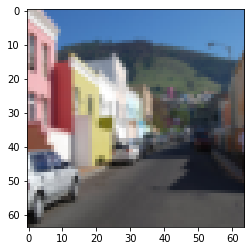

In [ ]:
index = 1
plt.imshow(train_set_x_orig[index])

In [ ]:
def layer_sizes(X,Y):
  n_x=X.shape[0] #size of input layer
  n_h=7         #size of hidden layer
  n_y=Y.shape[0] #size of output layer

  return n_x,n_h,n_y

**As usual we will follow the Deep Learning methodology to build the model: 1. Initialize parameters / Define hyperparameters 2. Loop for num_iterations: a. Forward propagation b. Compute cost function c. Backward propagation d. Update parameters (using parameters, and grads from backprop) 4. Use trained parameters to predict labels**

In [ ]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
  
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y,1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,"b1": b1,"W2": W2,"b2": b2}
    
    return parameters 

In [ ]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache  = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
    
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache=(linear_cache,activation_cache)

    return A, cache

**This part is directly used from one of the coursera assignment as this are the functions that can be easily calculated and also the documentation comments will help us to understand this code easily**

In [ ]:
def compute_cost(A2,Y):
    m=Y.shape[1]

   # cost = -1./m* np.sum(Y*np.log(A2) + (1-Y)*np.log(1-A2)) # i have USED THIS IN LOGISTIC REGRESSION
    half_cost = np.multiply(np.log(A2),Y) +  np.multiply(np.log(1-A2), (1-Y))
    cost = -1/m*np.sum(half_cost)

    return cost

In [ ]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m*np.dot(dZ, A_prev.T)
    db = 1./m*np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [ ]:
##By doing like this it will help us to create deep neural network
##just by calling this function and giving the activation function as a
## paramater we want.We require only one sigmoid at last layer and remaining
##according to the requirements  .
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":                                     
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  
  
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    
    return dA_prev, dW, db

In [ ]:
def update_parameters(parameters, grads, learning_rate):
  
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters


In [ ]:
layer_dims=layer_sizes(train_set_x,train_set_y)

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0078, num_iterations = 3000, print_cost=False):
    
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):

        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
    
        cost = compute_cost(A2, Y)
        
        
        # Calculating  dj/da  and initlaizing the backward propogation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dA1, dW2, db2 =  linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 =  linear_activation_backward(dA1, cache1, activation='relu')
    
  
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6936162964164335
Cost after iteration 100: 0.646048574341943
Cost after iteration 200: 0.6313625113604593
Cost after iteration 300: 0.5985026664047187
Cost after iteration 400: 0.5548719990060881
Cost after iteration 500: 0.5083125618757296
Cost after iteration 600: 0.4486503005013144
Cost after iteration 700: 0.408365688409051
Cost after iteration 800: 0.40530042257605475
Cost after iteration 900: 0.3703646233747492
Cost after iteration 1000: 0.34045826766759074
Cost after iteration 1100: 0.3099797596143704
Cost after iteration 1200: 0.29073593748932913
Cost after iteration 1300: 0.2643682237559935
Cost after iteration 1400: 0.33491752026184635
Cost after iteration 1500: 0.1606964605738221
Cost after iteration 1600: 0.12193765781373392
Cost after iteration 1700: 0.10078673359355449
Cost after iteration 1800: 0.08514249860682645
Cost after iteration 1900: 0.06937232570721186
Cost after iteration 2000: 0.060012623259366384
Cost after iteration 2100: 0.052361021

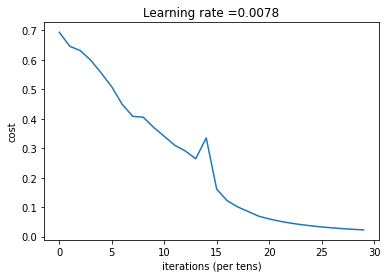

In [ ]:
params = two_layer_model(train_set_x, train_set_y, layer_dims, num_iterations = 3000, print_cost=True)


In [ ]:
def predict(params,X):
  w1=params["W1"]
  b1=params["b1"]
  w2=params["W2"]
  b2=params["b2"]
  Y_prediction = np.zeros((1,1))
  Z = np.dot(w1, X) + b1
  a1,use_less=relu(Z)
  Z2= np.dot(w2,a1) + b2 
  a2,use_less=sigmoid(Z2)

  for i in range(a2.shape[1]):
    
    if(a2[0][i]>0.5):
      Y_prediction[0][i]=1
    else:
      Y_prediction[0][i]=0
    
  return Y_prediction


**Testing our own image to check whther our algorithm is working properly or not**

Not a cat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


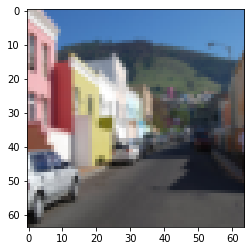

In [ ]:
index = 1
plt.imshow(train_set_x_orig[index])
img_flatten=train_set_x_orig[index].reshape(1,-1).T
a=predict(params,img_flatten)
if(a[0][0]>0.6):
  print("It is a cat")
else:
  print("Not a cat")

**In similar way we can also create as many as layers just by initializing the weights.The weigths are initialized by size of the current hidden layer i.e how many neurons are there in single layer and size of the previous hidden layer.**